Download data

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2023-03-20 01:54:17--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.90, 13.226.52.36, 13.226.52.51, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2023-03-20 01:54:17 (20.9 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [ ]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Polish', 'English', 'Vietnamese', 'German', 'Korean', 'Portuguese', 'Spanish', 'Russian', 'French', 'Italian', 'Chinese', 'Scottish', 'Arabic', 'Czech', 'Irish', 'Greek', 'Japanese', 'Dutch']
O'Neal


##Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





I. Previous Hidden Unit, Previous Character and Category
=======

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

II. Previous Hidden Unit and Previous Character
========

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, category):
        zeros = torch.zeros(1, self.hidden_size - n_categories)
        return torch.cat((category, zeros),1)

III. Previous Hidden Unit and Category
===========

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN3(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(RNN3, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, hidden):
        input_combined = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Iv. Previous Hidden Unit
========

In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN4(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(RNN4, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.i2h(hidden)
        output = self.i2o(hidden)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, category):
        zeros = torch.zeros(1, self.hidden_size - n_categories)
        return torch.cat((category, zeros),1)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [11]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [12]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [13]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




I.
======

In [7]:
criterion = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)

II.
======

In [14]:
criterion2 = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn2.initHidden(category_tensor)

    rnn2.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn2(input_line_tensor[i], hidden)
        l = criterion2(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer2.step()

    return output, loss.item() / input_line_tensor.size(0)

III.
======

In [17]:
criterion3 = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn3.initHidden()

    rnn3.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn3(category_tensor, hidden)
        l = criterion3(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer3.step()

    return output, loss.item() / input_line_tensor.size(0)

IV.
=====

In [20]:
criterion4 = nn.NLLLoss()

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn4.initHidden(category_tensor)

    rnn4.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn4(hidden)
        l = criterion4(output, target_line_tensor[i])
        loss += l

    # compute the gradient by backpropagation
    loss.backward()

    # update the parameters
    optimizer4.step()

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [8]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




I.
=====

In [9]:
rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses = []
all_validation_losses = []
train_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset(dataset):
    total_loss = 0
    n_instances = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
            total_loss += loss
    return total_loss / n_instances

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    train_loss += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every))

    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_generation_model.pt')
        all_validation_losses.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 28s) 	2.4359
5000 	12% 	(1m 2s) 	2.3596
7500 	18% 	(1m 35s) 	2.3253
10000 	25% 	(2m 9s) 	2.2596
12500 	31% 	(2m 42s) 	2.2220
15000 	37% 	(3m 15s) 	2.2480
17500 	43% 	(3m 48s) 	2.3012
20000 	50% 	(4m 20s) 	2.2314
22500 	56% 	(4m 53s) 	2.2212
25000 	62% 	(5m 25s) 	2.2385
27500 	68% 	(5m 59s) 	2.2127
30000 	75% 	(6m 31s) 	2.2306
32500 	81% 	(7m 4s) 	2.1906
35000 	87% 	(7m 36s) 	2.1641
37500 	93% 	(8m 9s) 	2.2065
40000 	100% 	(8m 44s) 	2.2366


II.
=====

In [15]:
rnn2 = RNN2(n_letters, 128, n_letters)
optimizer2 = torch.optim.Adam(rnn2.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses2 = []
all_validation_losses2 = []
train_loss2 = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate2(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn2.initHidden(category_tensor)
    loss = 0
    input_line_tensor = input_line_tensor.long()
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn2(input_line_tensor[i], hidden)
        loss += criterion2(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset2(dataset):
    total_loss2 = 0
    n_instances2 = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances2 += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate2(category_tensor, input_line_tensor, target_line_tensor)
            total_loss2 += loss
    return total_loss2 / n_instances2

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    train_loss2 += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss2 / plot_every))

    if iter % plot_every == 0:
        all_train_losses2.append(train_loss2 / plot_every)
        train_loss2 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss2 = eval_dataset2(validation_data)

        # save model with best validation loss
        if len(all_validation_losses2) == 0 or average_validation_loss2 < min(all_validation_losses2):
            torch.save(rnn2, 'char_rnn2_generation_model.pt')
        all_validation_losses2.append(average_validation_loss2)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 29s) 	2.5815
5000 	12% 	(1m 4s) 	2.3978
7500 	18% 	(1m 38s) 	2.3664
10000 	25% 	(2m 11s) 	2.3645
12500 	31% 	(2m 46s) 	2.3074
15000 	37% 	(3m 20s) 	2.3175
17500 	43% 	(3m 54s) 	2.2658
20000 	50% 	(4m 29s) 	2.2745
22500 	56% 	(5m 3s) 	2.2568
25000 	62% 	(5m 37s) 	2.2845
27500 	68% 	(6m 12s) 	2.2169
30000 	75% 	(6m 47s) 	2.2706
32500 	81% 	(7m 21s) 	2.2462
35000 	87% 	(7m 55s) 	2.2434
37500 	93% 	(8m 30s) 	2.2386
40000 	100% 	(9m 5s) 	2.1894


III.
======

In [18]:
rnn3 = RNN3(128, n_letters)
optimizer3 = torch.optim.Adam(rnn3.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses3 = []
all_validation_losses3 = []
train_loss3 = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate3(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn3.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn3(category_tensor, hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset3(dataset):
    total_loss3 = 0
    n_instances3 = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances3 += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate3(category_tensor, input_line_tensor, target_line_tensor)
            total_loss3 += loss
    return total_loss3 / n_instances3

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    train_loss3 += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss3 / plot_every))

    if iter % plot_every == 0:
        all_train_losses3.append(train_loss3 / plot_every)
        train_loss3 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss3 = eval_dataset3(validation_data)

        # save model with best validation loss
        if len(all_validation_losses3) == 0 or average_validation_loss3 < min(all_validation_losses3):
            torch.save(rnn3, 'char_rnn3_generation_model.pt')
        all_validation_losses3.append(average_validation_loss3)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 28s) 	2.7122
5000 	12% 	(1m 0s) 	2.6841
7500 	18% 	(1m 31s) 	2.6457
10000 	25% 	(2m 2s) 	2.6342
12500 	31% 	(2m 33s) 	2.6590
15000 	37% 	(3m 4s) 	2.6038
17500 	43% 	(3m 36s) 	2.6200
20000 	50% 	(4m 7s) 	2.5957
22500 	56% 	(4m 38s) 	2.6303
25000 	62% 	(5m 10s) 	2.6445
27500 	68% 	(5m 42s) 	2.5954
30000 	75% 	(6m 13s) 	2.6060
32500 	81% 	(6m 44s) 	2.5981
35000 	87% 	(7m 15s) 	2.5870
37500 	93% 	(7m 46s) 	2.5803
40000 	100% 	(8m 18s) 	2.6002


IV.
=====

In [21]:
rnn4 = RNN4(128, n_letters)
optimizer4 = torch.optim.Adam(rnn4.parameters())


n_iters = 40000
print_every = 2500
plot_every = 500
all_train_losses4 = []
all_validation_losses4 = []
train_loss4 = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate4(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn4.initHidden(category_tensor)
    loss = 0
    input_line_tensor = input_line_tensor.long()
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn4(hidden)
        loss += criterion4(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

def eval_dataset4(dataset):
    total_loss4 = 0
    n_instances4 = 0
    for category in all_categories:
        category_tensor = Variable(categoryTensor(category))
        n_instances4 += len(dataset[category])
        for line in dataset[category]:
            input_line_tensor = Variable(inputTensor(line))
            target_line_tensor = Variable(targetTensor(line))
            output, loss = evaluate4(category_tensor, input_line_tensor, target_line_tensor)
            total_loss4 += loss
    return total_loss4 / n_instances4

start = time.time()
print('\nIter \tTrain% \tTime \t\tTrain_loss')
for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    train_loss4 += loss

    if iter % print_every == 0:
        print('%d \t%d%% \t(%s) \t%.4f' % (iter, iter / n_iters * 100, timeSince(start), train_loss4 / plot_every))

    if iter % plot_every == 0:
        all_train_losses4.append(train_loss4 / plot_every)
        train_loss4 = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss4 = eval_dataset4(validation_data)

        # save model with best validation loss
        if len(all_validation_losses4) == 0 or average_validation_loss4 < min(all_validation_losses4):
            torch.save(rnn4, 'char_rnn4_generation_model.pt')
        all_validation_losses4.append(average_validation_loss4)


Iter 	Train% 	Time 		Train_loss
2500 	6% 	(0m 25s) 	2.8381
5000 	12% 	(0m 56s) 	2.7655
7500 	18% 	(1m 25s) 	2.6918
10000 	25% 	(1m 57s) 	2.7049
12500 	31% 	(2m 28s) 	2.6901
15000 	37% 	(3m 0s) 	2.6674
17500 	43% 	(3m 31s) 	2.6986
20000 	50% 	(4m 1s) 	2.7010
22500 	56% 	(4m 32s) 	2.7096
25000 	62% 	(5m 2s) 	2.6822
27500 	68% 	(5m 31s) 	2.6493
30000 	75% 	(6m 2s) 	2.6645
32500 	81% 	(6m 33s) 	2.6416
35000 	87% 	(7m 4s) 	2.6317
37500 	93% 	(7m 34s) 	2.5862
40000 	100% 	(8m 4s) 	2.6443


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




Average test loss: 2.4388324540510617


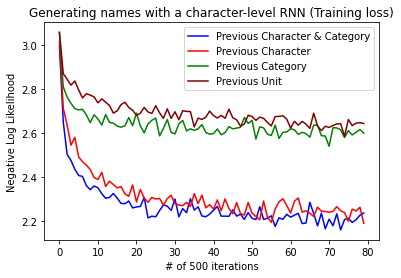

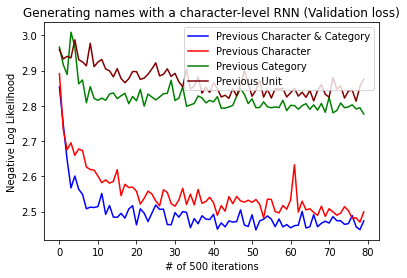

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses, color = "blue", label = "Previous Character & Category")
plt.plot(all_train_losses2, color = "red", label = "Previous Character")
plt.plot(all_train_losses3, color = "green", label = "Previous Category")
plt.plot(all_train_losses4, color = "maroon", label = "Previous Unit")


plt.title('Generating names with a character-level RNN (Training loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(loc='upper right')

plt.figure()
plt.plot(all_validation_losses, color = "blue", label = "Previous Character & Category")
plt.plot(all_validation_losses2, color = "red", label = "Previous Character")
plt.plot(all_validation_losses3, color = "green", label = "Previous Category")
plt.plot(all_validation_losses4, color = "maroon", label = "Previous Unit")

plt.title('Generating names with a character-level RNN (Validation loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 500 iterations')
plt.legend(loc='upper right')

# evaluate on test set and print average test loss
rnn = torch.load('char_rnn_generation_model.pt')
average_test_loss = eval_dataset(test_data)
print('Average test loss: ' + str(average_test_loss))

Explanation
======
If the previous character or category is used as input, it may improve the model's predictions by providing info on characters that have been generated so far. Hence the reason for the performance improvements in the graphs above with those inputs.



Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [23]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rohalov
Ushinov
Shilov
Guren
Esper
Romen
Sander
Pallan
Abbar
Chan
Han
Ina


Exercises
=========

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the nn.LSTM and nn.GRU layers
   -  Combine multiple of these RNNs as a higher level network


